In [1]:
%pylab inline
import scipy.spatial.distance as sdist

Populating the interactive namespace from numpy and matplotlib


## Detect outliers using KMeans Clustering

### Generate data

In [52]:
n_samples = 50
n_outliers = 10
n_features = 2

gen_cov = np.eye(n_features)
gen_cov[0, 0] = 2.
#gen_cov[1, 1] = 1.5
X = np.dot(np.random.randn(n_samples, n_features), gen_cov)

### Add some outliers

In [53]:
outliers_cov = np.eye(n_features)
#outliers_cov[0,0] = 5.
outliers_cov[1,1] = 7.
X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), outliers_cov)

### k-means--: A unified approach to clustering and outlier detection
http://knowledgecenter.siam.org/204SDM/~~PdfSource/0

In [15]:
class KMeansOutlier1():
    def __init__(self, numClust, numOutlier, convergeDist=0.1):
        self._k = numClust
        self._l = numOutlier
        self.L = []
        self.XI = []
        self.C = []
        self._i = 0
        self._cD = convergeDist
    
    def _centI(self, x, C):
        return np.argmin([sdist.euclidean(x, c) for c in C])

    def _cent(self, x, C):
        return C[self._centI(x,C)]

    def _dist(self, x, C):
        return sdist.euclidean(x, self._cent(x, C))
    
    def fit(self, X):
        self.L.append([])
        self.XI.append(X)
        self.C.append(self.XI[0][np.random.choice(X.shape[0], self._k, replace=False)])
        self._i = 1
        return self
    
    def DetectOutlier(self):
        convergence = False
        while not convergence:
            # Compute d(x | Ci-1) for all x in X
            # Re-order the points in X by decreasing distance
            XO = self.XI[0][np.argsort([self._dist(x, self.C[self._i-1]) for x in self.XI[0]])[::-1]]
            # Save off l 'outliers'
            self.L.append(XO[:self._l])
            # Generate new list of points
            self.XI.append(XO[self._l:])
            # Assign points to centers
            P = {j:[] for j in xrange(self._k)}
            for x in self.XI[self._i]:
                P[self._centI(x, self.C[self._i-1])].append(x)
            # Calculate new centers
            self.C.append(np.array([np.mean(P[j],0) for j in xrange(self._k)]))
            if np.linalg.norm(self.C[self._i-1] - self.C[self._i]) < self._cD:
                convergence = True
            else:
                self._i += 1
        return self.L[self._i]
        

In [32]:
kmo = KMeansOutlier1(int(n_samples*0.002), int(n_samples*0.002)*2).fit(X)
outliers = kmo.DetectOutlier()

In [33]:
print kmo._i, kmo._k, kmo._l

12 10 20


### Outlier Detection using Improved Genetic K-means
http://knowledgecenter.siam.org/204SDM/~~PdfSource/0

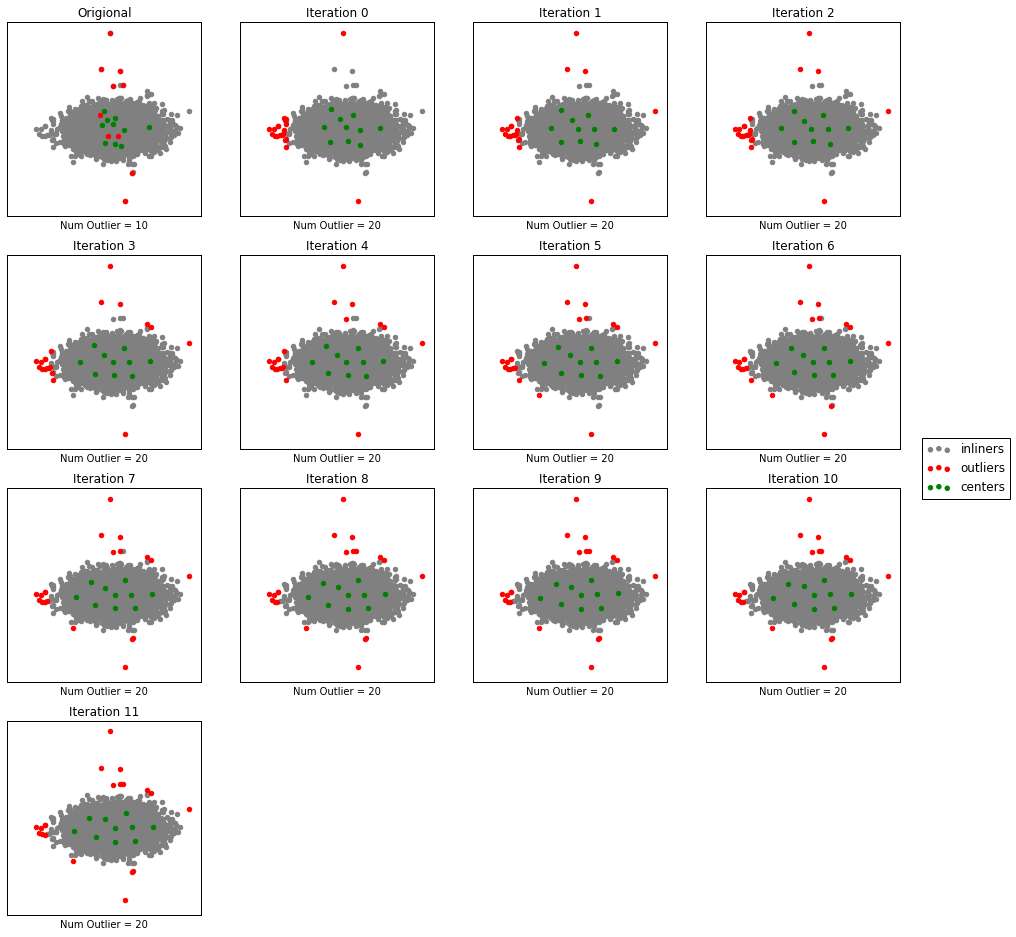

In [34]:
n_rows = int((kmo._i)/4.0)+1
fig, ax = plt.subplots(n_rows,4, sharey=True, figsize=(16,n_rows*4))
pts = []

subfig = plt.subplot(n_rows, 4, 1) #ax[0][0]#
pts.append(subfig.scatter(X[:, 0], X[:, 1], color='gray'))
pts.append(subfig.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:], color='red'))
pts.append(subfig.scatter(kmo.C[0][:,0], kmo.C[0][:,1], color='green'))
subfig.set_title('Origional')
subfig.set_xlabel('Num Outlier = '+str(n_outliers))
subfig.set_xticks(())
subfig.set_yticks(())

for j in xrange(kmo._i):
    subfig = plt.subplot(n_rows, 4, j+2)
    subfig.scatter(kmo.XI[j+1][:,0], kmo.XI[j+1][:,1], color='gray')
    subfig.scatter(kmo.L[j+1][:,0], kmo.L[j+1][:,1], color='red')
    subfig.scatter([c[0] for c in kmo.C[j+1]], [c[1] for c in kmo.C[j+1]], color='green')
    subfig.set_xlabel('Num Outlier = %d'%(len(kmo.L[j+1])))
    subfig.set_title('Iteration %d'%(j))
    subfig.set_xticks(())
    subfig.set_yticks(())

# Blank out the rest
for j in xrange(kmo._i+1, n_rows*4):
    subfig = plt.subplot(n_rows, 4, j+1)
    subfig.axis('off')
    
fig.legend(pts, ('inliners', 'outliers', 'centers'), ncol=1, loc='center right')

In [54]:
np.savetxt('t_data.csv', X, delimiter=',',fmt='%.6f')

In [55]:
!head -n 10 t_data.csv

-0.669675,-0.348210
2.184766,-1.463912
-0.366369,0.017956
-2.519255,0.734360
0.709305,1.433370
0.690349,-0.561075
1.530121,0.593288
-2.203607,-1.291902
-0.693652,-0.472910
-0.431918,0.416305


In [51]:
%pwd

u'/Users/johngill/Documents/DSE/jgilliii/dse_capstone/ml/notebooks'